In [1]:
# Import necessary libraries
import os
import sys

# Add the scripts folder to the Python path
sys.path.append(os.path.abspath("../scripts"))

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from load_data import fetch_data
from compute_engagement_score import compute_engagement_score
from compute_experience_score import compute_experience_score
from compute_satisfaction_score import compute_satisfaction_score
from export_results import export_to_mysql
from clustering_analysis import perform_clustering
from regression_model import train_regression_model


In [2]:

# SQL query to fetch data
query = "SELECT * FROM xdr_data ;"  

# Load the data
df = fetch_data(query)

d:\Kifya_training\Week 2\Telecom-User-Analysis-and-Dashboard-Development\scripts\load_data.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [13]:
# Prepare data for clustering: select relevant columns and handle missing data
relevant_columns = [
    'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)', 'Total DL (Bytes)', 'Total UL (Bytes)'
]

df = df[relevant_columns].dropna()  # Drop rows with missing values

In [14]:
# Standardize the data (important for K-means clustering)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [15]:
# Perform K-means clustering to compute centroids
n_clusters = 2  # Assuming two clusters: engagement and experience
kmeans, labels = perform_clustering(scaled_data, n_clusters)

In [16]:
# Get the centroids from the model
centroids = kmeans.cluster_centers_

# Inverse transform the centroids to get them in the original scale
original_centroids = scaler.inverse_transform(centroids)

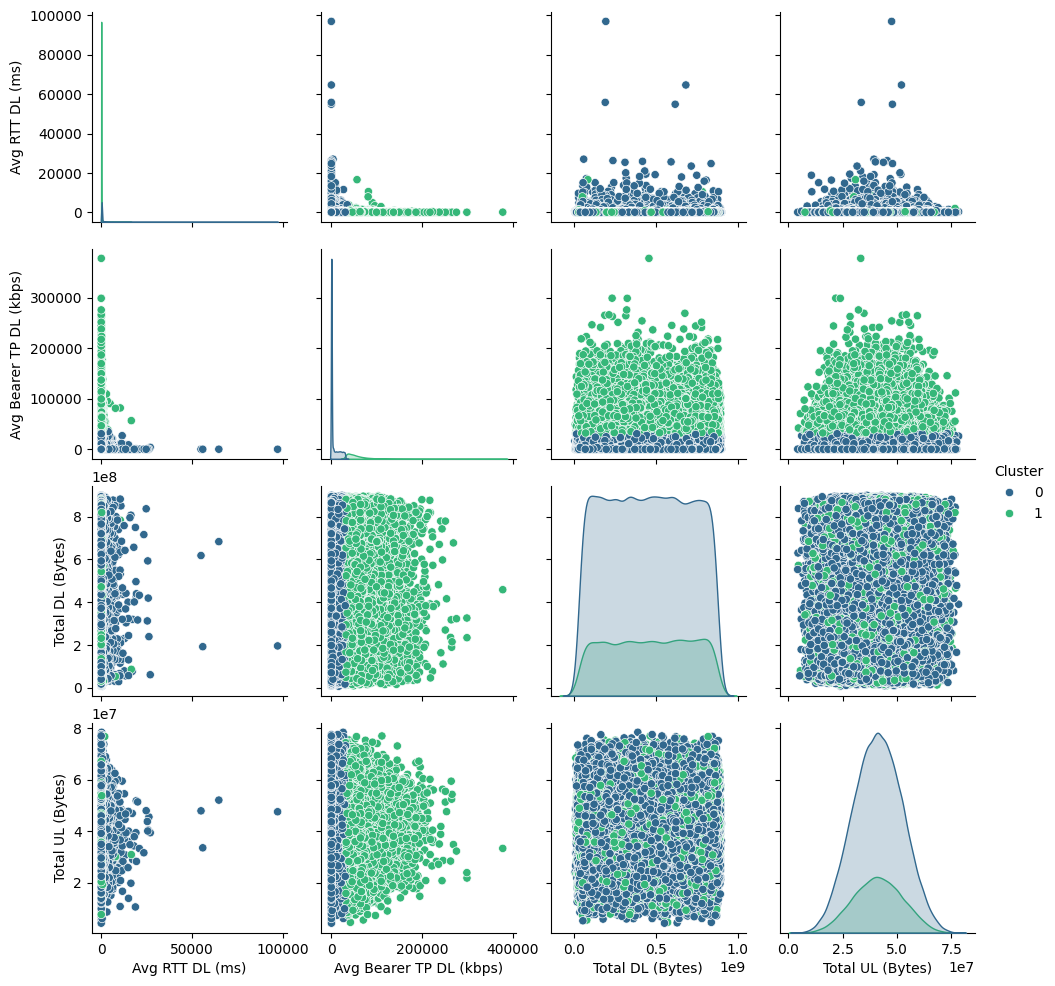

In [17]:
# Add cluster labels to the original data
df['Cluster'] = labels

# Visualize clusters using pairplot
sns.pairplot(df[relevant_columns + ['Cluster']], hue='Cluster', palette="viridis", diag_kind="kde")
plt.show()

In [18]:
# Compute engagement and experience scores
engagement_scores = compute_engagement_score(df[relevant_columns], original_centroids[0])  # Centroid for engagement cluster
experience_scores = compute_experience_score(df[relevant_columns], original_centroids[1])  # Centroid for experience cluster

# Compute satisfaction scores as the average of engagement and experience scores
satisfaction_scores = compute_satisfaction_score(engagement_scores, experience_scores)

# Add the satisfaction scores to the dataframe
df['Satisfaction Score'] = satisfaction_scores

In [34]:
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import dump

def train_regression_model(X, y):
    # Initialize the regression model
    model = LinearRegression()
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions
    predictions = model.predict(X)
    
    # Calculate loss (mean squared error)
    loss = mean_squared_error(y, predictions)
    
    # Create the directory if it doesn't exist
    model_directory = "../models"
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    
    # Save the model to the file
    dump(model, os.path.join(model_directory, "regression_model.pkl"))
    
    return model, loss
